## Overall goals of this Notebook:
<li>Turn raw text into something that a neural network can process.
<li>Use the Embedding layer in a Keras model to learn task-specific token embeddings.
<li>Leverage pre-trained word embeddings to get an extra boost on small natural language processing problems.
#### Processing the labels of the raw IMDB <b>review</b> data
<li>The raw IMDB data is at http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
<li>gzip -d aclImdb_v1.tar.gz
<li>tar xvf aclImdb_v1.tar

In [1]:
import os
imdb_dir = '/Users/keeyong/Downloads/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

#### 트레이닝 데이터를 texts와 labels의 두개로 나눠서 저장
<li> texts에는 텍스트를 저장 (Features)
<li> labels에는 말그대로 판정결과를 저장

In [2]:
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

#### Tokenizing the text of the raw IMDB data

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

Using TensorFlow backend.


In [4]:
maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

In [5]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [6]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [7]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [8]:
# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [9]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

#### DOWNLOAD THE GLOVE WORD EMBEDDINGS
<li> https://nlp.stanford.edu/projects/glove/
<li> http://nlp.stanford.edu/data/glove.6B.zip

#### Parsing the GloVe word embeddings file

In [10]:
glove_dir = '/Users/keeyong/Downloads/glove.6B'

In [11]:
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


#### Preparing the GloVe word embeddings matrix

In [12]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

#### DEFINE A MODEL

In [13]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [14]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


####  Loading the matrix of pre-trained word embeddings into the Embedding layer

In [15]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

#### TRAIN AND EVALUATE

In [16]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s - loss: 2.6931 - acc: 0.4700 - val_loss: 0.7211 - val_acc: 0.5505
Epoch 2/10
200/200 [==============================] - 0s - loss: 0.4967 - acc: 0.7350 - val_loss: 1.9693 - val_acc: 0.4956
Epoch 3/10
200/200 [==============================] - 0s - loss: 0.3348 - acc: 0.9250 - val_loss: 0.9367 - val_acc: 0.5242
Epoch 4/10
200/200 [==============================] - 0s - loss: 0.1986 - acc: 0.9400 - val_loss: 1.5297 - val_acc: 0.4959
Epoch 5/10
200/200 [==============================] - 0s - loss: 0.4602 - acc: 0.7000 - val_loss: 1.0402 - val_acc: 0.5116
Epoch 6/10
200/200 [==============================] - 0s - loss: 0.0870 - acc: 0.9950 - val_loss: 0.7424 - val_acc: 0.5666
Epoch 7/10
200/200 [==============================] - 0s - loss: 0.0455 - acc: 1.0000 - val_loss: 0.7637 - val_acc: 0.5660
Epoch 8/10
200/200 [==============================] - 0s - loss: 0.0346 - acc: 1.0000 - val

#### Plotting results

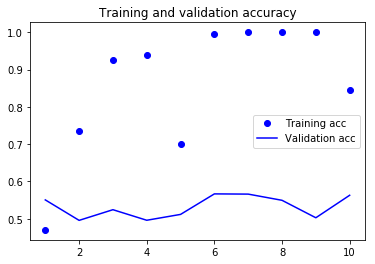

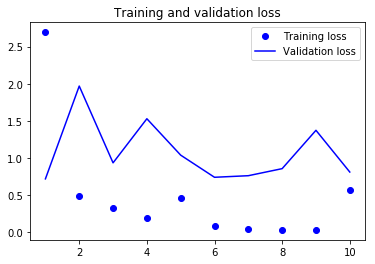

In [17]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

####  Defining a training the same model without pre-trained word embeddings
In that case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings when <b>lots of data</b> is available.

In [18]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [19]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [22]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s - loss: 0.6920 - acc: 0.5300 - val_loss: 0.6916 - val_acc: 0.5217
Epoch 2/10
200/200 [==============================] - 0s - loss: 0.4772 - acc: 0.9650 - val_loss: 0.6961 - val_acc: 0.5179
Epoch 3/10
200/200 [==============================] - 0s - loss: 0.2453 - acc: 0.9950 - val_loss: 0.7132 - val_acc: 0.5324
Epoch 4/10
200/200 [==============================] - 0s - loss: 0.1058 - acc: 0.9950 - val_loss: 0.6990 - val_acc: 0.5302
Epoch 5/10
200/200 [==============================] - 0s - loss: 0.0486 - acc: 1.0000 - val_loss: 0.7066 - val_acc: 0.5352
Epoch 6/10
200/200 [==============================] - 0s - loss: 0.0255 - acc: 1.0000 - val_loss: 0.7171 - val_acc: 0.5324
Epoch 7/10
200/200 [==============================] - 0s - loss: 0.0143 - acc: 1.0000 - val_loss: 0.7128 - val_acc: 0.5343
Epoch 8/10
200/200 [==============================] - 0s - loss: 0.0083 - acc: 1.0000 - val

#### Evaluate the model on the test data
First, we will need to tokenize the test data

In [21]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

In [22]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

####  Evaluating the model on the test set

In [26]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

24992/25000 [============================>.] - ETA: 0s

[0.81356566606521608, 0.55667999999999995]